In [10]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import pynapple as nap

from spatial_manifolds.util import gaussian_filter_nan
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def wrap_list(obj):
    return obj if isinstance(obj, list | tuple) else [obj]


def compute_travel_projected(var_label, var_values, P, travel):
    n = len(P)

    # Compute cumulative distances based on dimensionality
    if P.ndim == 1:
        segment_lengths = np.abs(np.diff(P))
    else:
        deltas = np.diff(P, axis=0)
        segment_lengths = np.linalg.norm(deltas, axis=1)

    cum_distances = np.insert(np.cumsum(segment_lengths), 0, 0)

    projected_vals = []
    valid_times = []
    j = 0
    times = P.times()

    for i in range(n):
        target_distance = cum_distances[i] + travel

        # Advance j until we find the segment that contains the projected distance
        while j < n and cum_distances[j] < target_distance:
            j += 1

        if j >= n:
            break  # Stop if out of bounds

        d1 = cum_distances[j - 1]
        d2 = cum_distances[j]
        t = (target_distance - d1) / (d2 - d1)

        interp_val = var_values[j - 1] + t * (
            var_values[j] - var_values[j - 1]
        )

        projected_vals.append(interp_val)
        valid_times.append(times[i])

    projected_vals = np.array(projected_vals)
    valid_times = np.array(valid_times)

    return nap.TsdFrame(
        t=valid_times, d=projected_vals, columns=wrap_list(var_label)
    )

In [49]:
mouse = 25
day =  25
session = 'OF2'
of2_folder = f'/Users/harryclark/Downloads/COHORT12_nwb/M{mouse}/D{day:02}/{session}/'
grid_path = of2_folder + "tuning_scores/grid_score.parquet"
shifted_grid_path = of2_folder + "tuning_scores/shifted_grid_score.parquet"
spatial_path = of2_folder + "tuning_scores/shifted_spatial_information.parquet"
spatial_stab_path = of2_folder + "tuning_scores/spatial_stability.parquet"
spikes_path = of2_folder + f"sub-{mouse}_day-{day:02}_ses-{session}_srt-kilosort4_clusters.npz"
beh_path = of2_folder + f"sub-{mouse}_day-{day:02}_ses-{session}_beh.nwb"
active_projects_path = Path("/Volumes/cmvm/sbms/groups/CDBS_SIDB_storage/NolanLab/ActiveProjects/")
anatomy_path = active_projects_path / "Chris/Cohort12/derivatives/labels/anatomy/cluster_annotations.csv"
cluster_locations = pd.read_csv(anatomy_path)
beh = nap.load_file(beh_path)
clusters = nap.load_file(spikes_path)
shifted_grid_scores_of2 = pd.read_parquet(shifted_grid_path)
spatial_information_score_of2 = pd.read_parquet(spatial_path)
spatial_stability_score_of2 = pd.read_parquet(spatial_stab_path)

session = 'OF1'
of1_folder = f'/Users/harryclark/Downloads/COHORT12_nwb/M{mouse}/D{day:02}/{session}/'
grid_path = of1_folder + "tuning_scores/grid_score.parquet"
shifted_grid_path = of1_folder + "tuning_scores/shifted_grid_score.parquet"
spatial_path = of1_folder + "tuning_scores/shifted_spatial_information.parquet"
spatial_stab_path = of1_folder + "tuning_scores/spatial_stability.parquet"
spikes_path = of1_folder + f"sub-{mouse}_day-{day:02}_ses-{session}_srt-kilosort4_clusters.npz"
beh_path = of1_folder + f"sub-{mouse}_day-{day:02}_ses-{session}_beh.nwb"
active_projects_path = Path("/Volumes/cmvm/sbms/groups/CDBS_SIDB_storage/NolanLab/ActiveProjects/")
anatomy_path = active_projects_path / "Chris/Cohort12/derivatives/labels/anatomy/cluster_annotations.csv"
cluster_locations = pd.read_csv(anatomy_path)
beh = nap.load_file(beh_path)
clusters = nap.load_file(spikes_path)
shifted_grid_scores_of1 = pd.read_parquet(shifted_grid_path)
spatial_information_score_of1 = pd.read_parquet(spatial_path)
spatial_stability_score_of1 = pd.read_parquet(spatial_stab_path)

In [93]:
cells = shifted_grid_scores_of1.query('travel == 0')

grid_cells = pd.DataFrame()
non_grid_cells = pd.DataFrame()

percentile_val = 95
for index in cells.cluster_id:
    #=======OF1============
    cluster_spatial_information_of1 = spatial_information_score_of1[spatial_information_score_of1.cluster_id==index]
    cluster_shifted_grid_scores_of1 = shifted_grid_scores_of1[shifted_grid_scores_of1.cluster_id==index]
    cluster_spatial_stability_of1 = spatial_stability_score_of1[spatial_stability_score_of1.cluster_id==index]

    # remove negative spatial lag
    cluster_shifted_grid_scores_of1 = cluster_shifted_grid_scores_of1[(cluster_shifted_grid_scores_of1.travel>-1) & (cluster_shifted_grid_scores_of1.travel<25)]
    cluster_spatial_information_of1 = cluster_spatial_information_of1[(cluster_spatial_information_of1.travel>-1) & (cluster_spatial_information_of1.travel<25)]

    max_gs_idx = np.nanargmax(cluster_shifted_grid_scores_of1.grid_score)

    max_grid_score_travel = np.array(cluster_shifted_grid_scores_of1.travel)[max_gs_idx]
    max_grid_score_si_of1 = np.array(cluster_spatial_information_of1.spatial_information)[max_gs_idx]
    max_grid_score_of1 = np.array(cluster_shifted_grid_scores_of1.grid_score)[max_gs_idx]
    cluster_stability_of1 = cluster_spatial_stability_of1.stability.iloc[0]

    percentile_grid_score_of1 = np.nanpercentile(cluster_shifted_grid_scores_of1.null_grid_score.iloc[0], percentile_val)
    percentile_spatial_information_of1 = np.nanpercentile(cluster_spatial_information_of1.null_spatial_information.iloc[0], percentile_val)
    percentile_spatial_stability_of1 = np.nanpercentile(cluster_spatial_stability_of1.null_stability.iloc[0], percentile_val)

    #=======OF1============



    #=======OF2============
    cluster_spatial_information_of2 =spatial_information_score_of2[spatial_information_score_of2.cluster_id==index]
    cluster_shifted_grid_scores_of2 = shifted_grid_scores_of2[shifted_grid_scores_of2.cluster_id==index]
    cluster_spatial_stability_of2 = spatial_stability_score_of2[spatial_stability_score_of2.cluster_id==index]

    # remove negative spatial lag
    cluster_shifted_grid_scores_of2 = cluster_shifted_grid_scores_of2[(cluster_shifted_grid_scores_of2.travel>-1) & (cluster_shifted_grid_scores_of2.travel<25)]
    cluster_spatial_information_of2 = cluster_spatial_information_of2[(cluster_spatial_information_of2.travel>-1) & (cluster_spatial_information_of2.travel<25)]

    max_gs_idx = np.nanargmax(cluster_shifted_grid_scores_of2.grid_score)

    max_grid_score_travel = np.array(cluster_shifted_grid_scores_of2.travel)[max_gs_idx]
    max_grid_score_si_of2 = np.array(cluster_spatial_information_of2.spatial_information)[max_gs_idx]
    max_grid_score_of2 = np.array(cluster_shifted_grid_scores_of2.grid_score)[max_gs_idx]
    cluster_stability_of2 = cluster_spatial_stability_of2.stability.iloc[0]

    percentile_grid_score_of2 = np.nanpercentile(cluster_shifted_grid_scores_of2.null_grid_score.iloc[0], percentile_val)
    percentile_spatial_information_of2 = np.nanpercentile(cluster_spatial_information_of2.null_spatial_information.iloc[0], percentile_val)
    percentile_spatial_stability_of2 = np.nanpercentile(cluster_spatial_stability_of2.null_stability.iloc[0], percentile_val)
    #=======OF2============


    if (max_grid_score_of1 > percentile_grid_score_of1) & (max_grid_score_of1 > 0.5) and (cluster_stability_of1 > percentile_spatial_stability_of1):
        grid_cells = pd.concat([grid_cells, cells[cells.cluster_id == index]], ignore_index=True)
    else:
        non_grid_cells = pd.concat([non_grid_cells, cells[cells.cluster_id == index]], ignore_index=True)

print(f'there are {len(grid_cells)} grid_cells')
print(f'there are {len(non_grid_cells)} non grid cells')

there are 49 grid_cells
there are 103 non grid cells


making plots for grid_cells


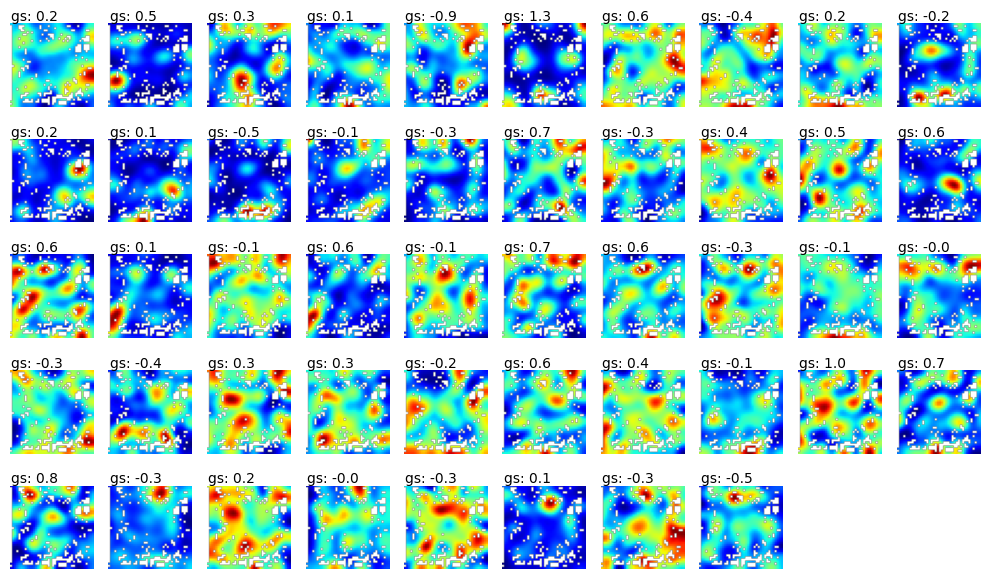

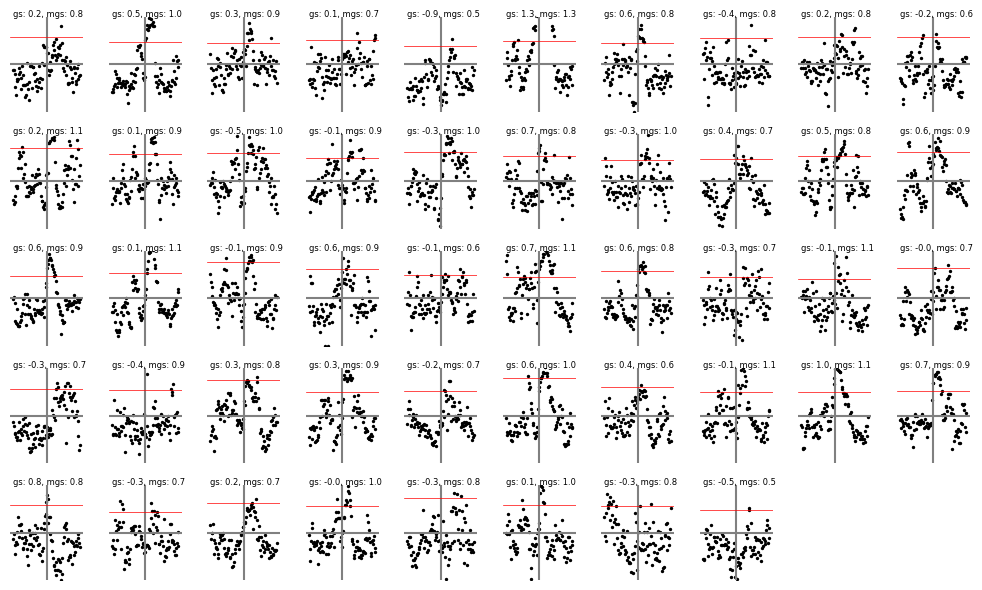

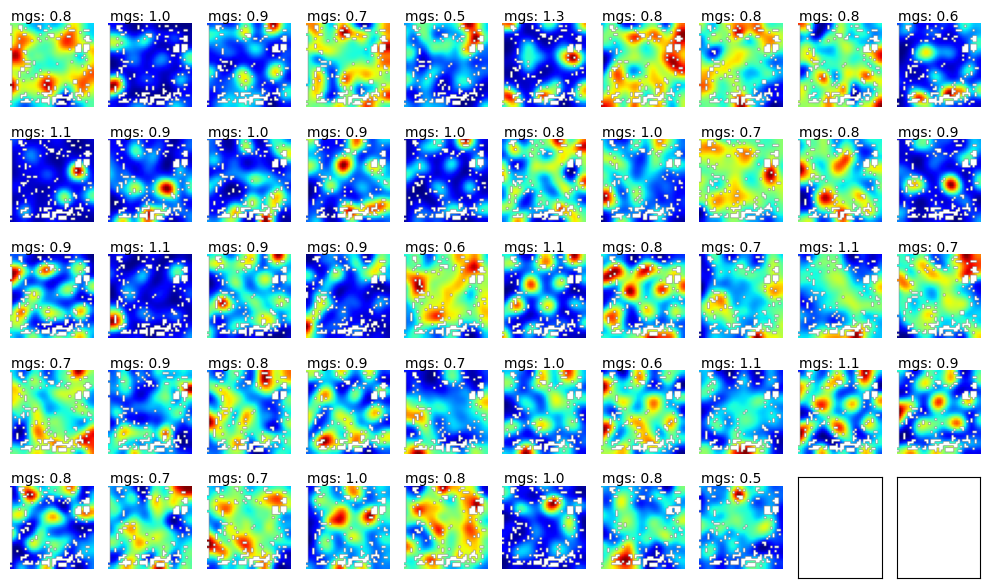

making plots for Nongrids


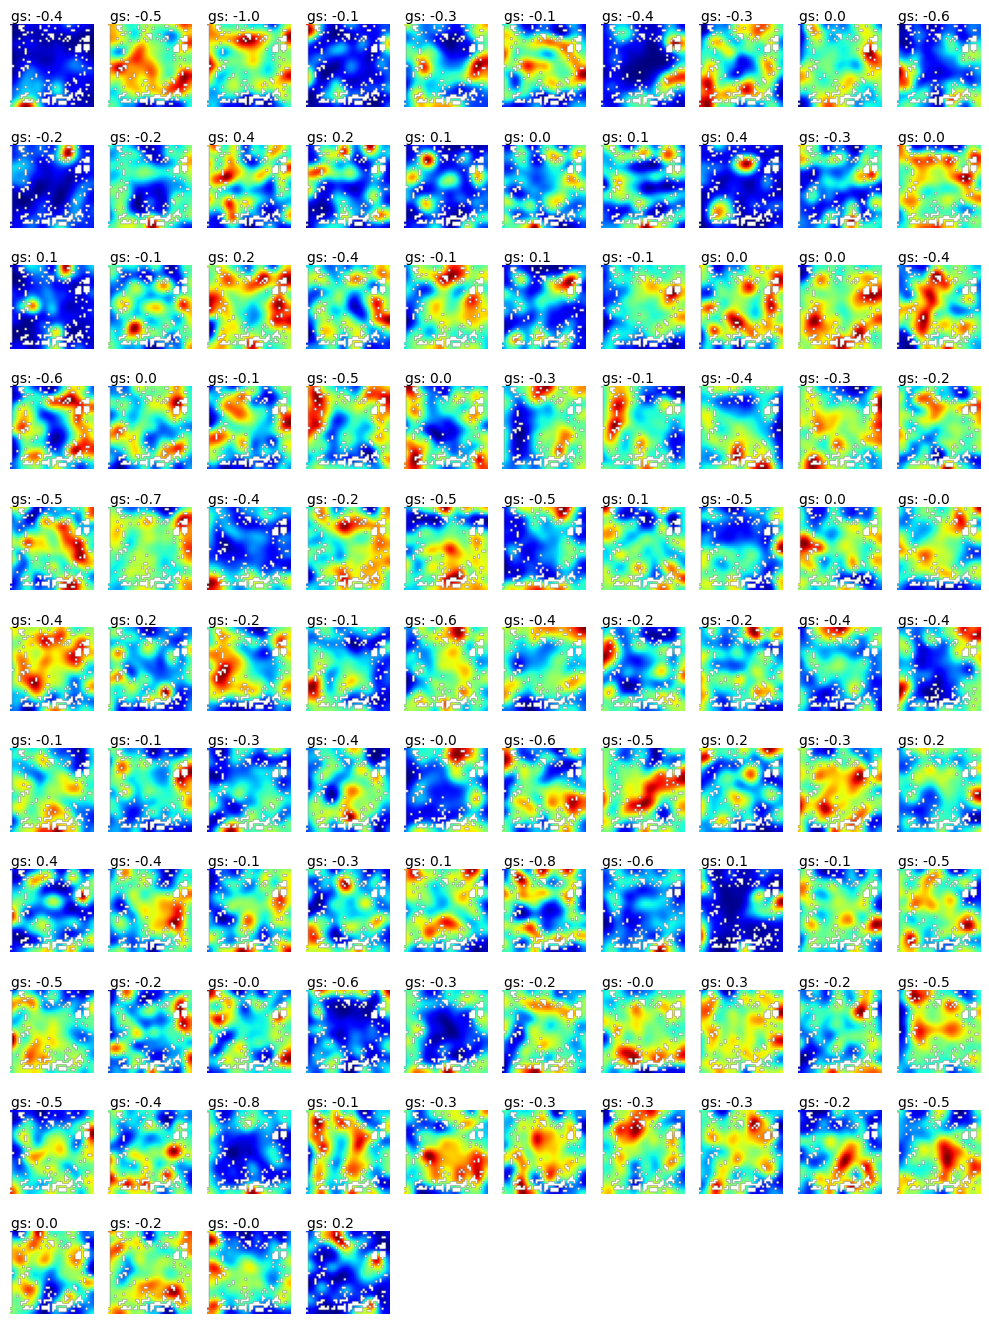

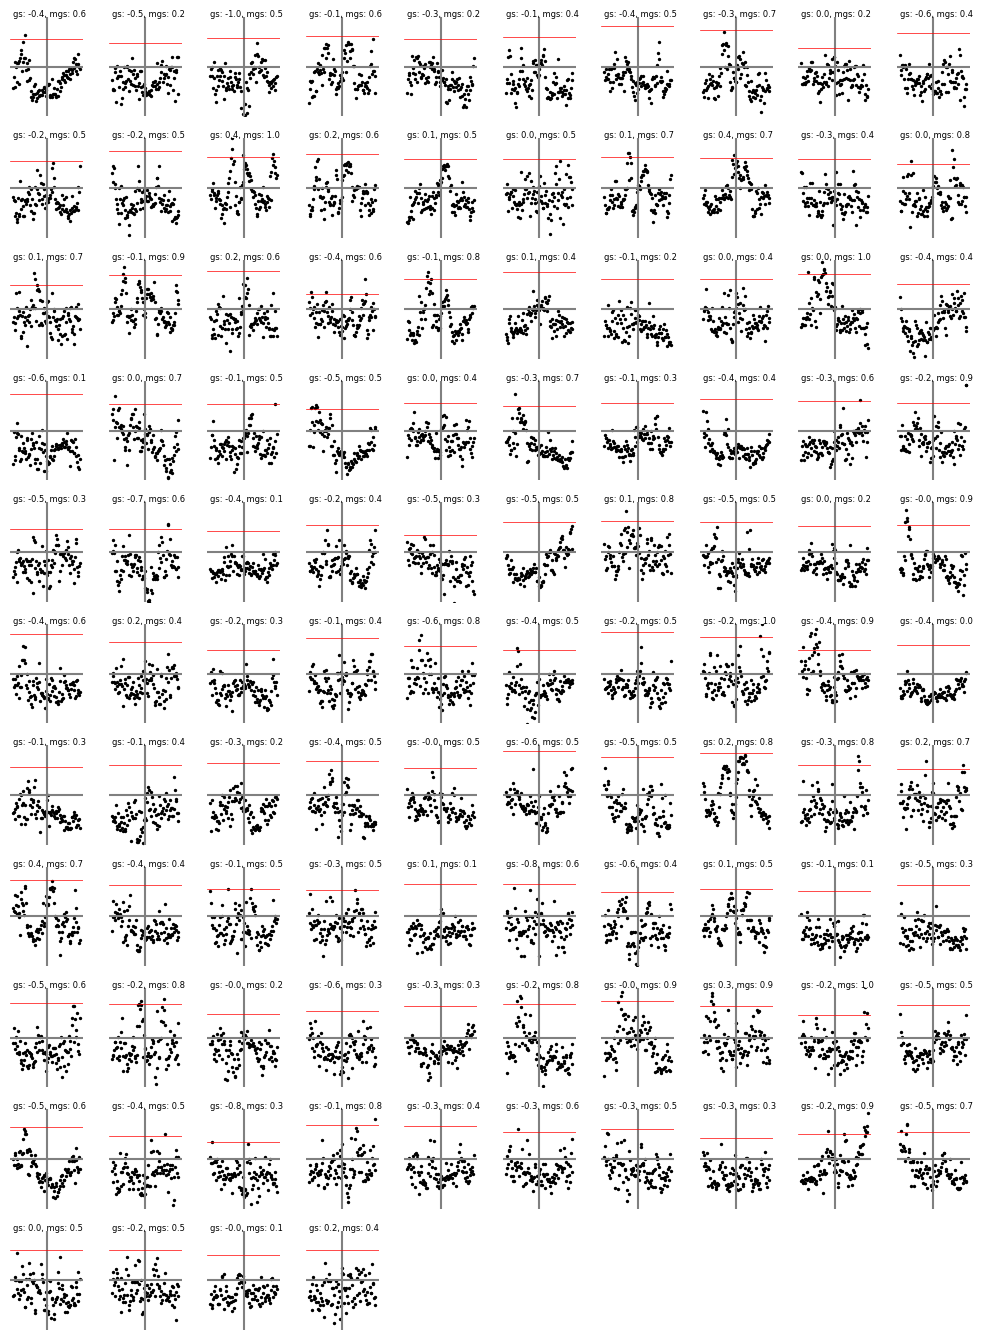

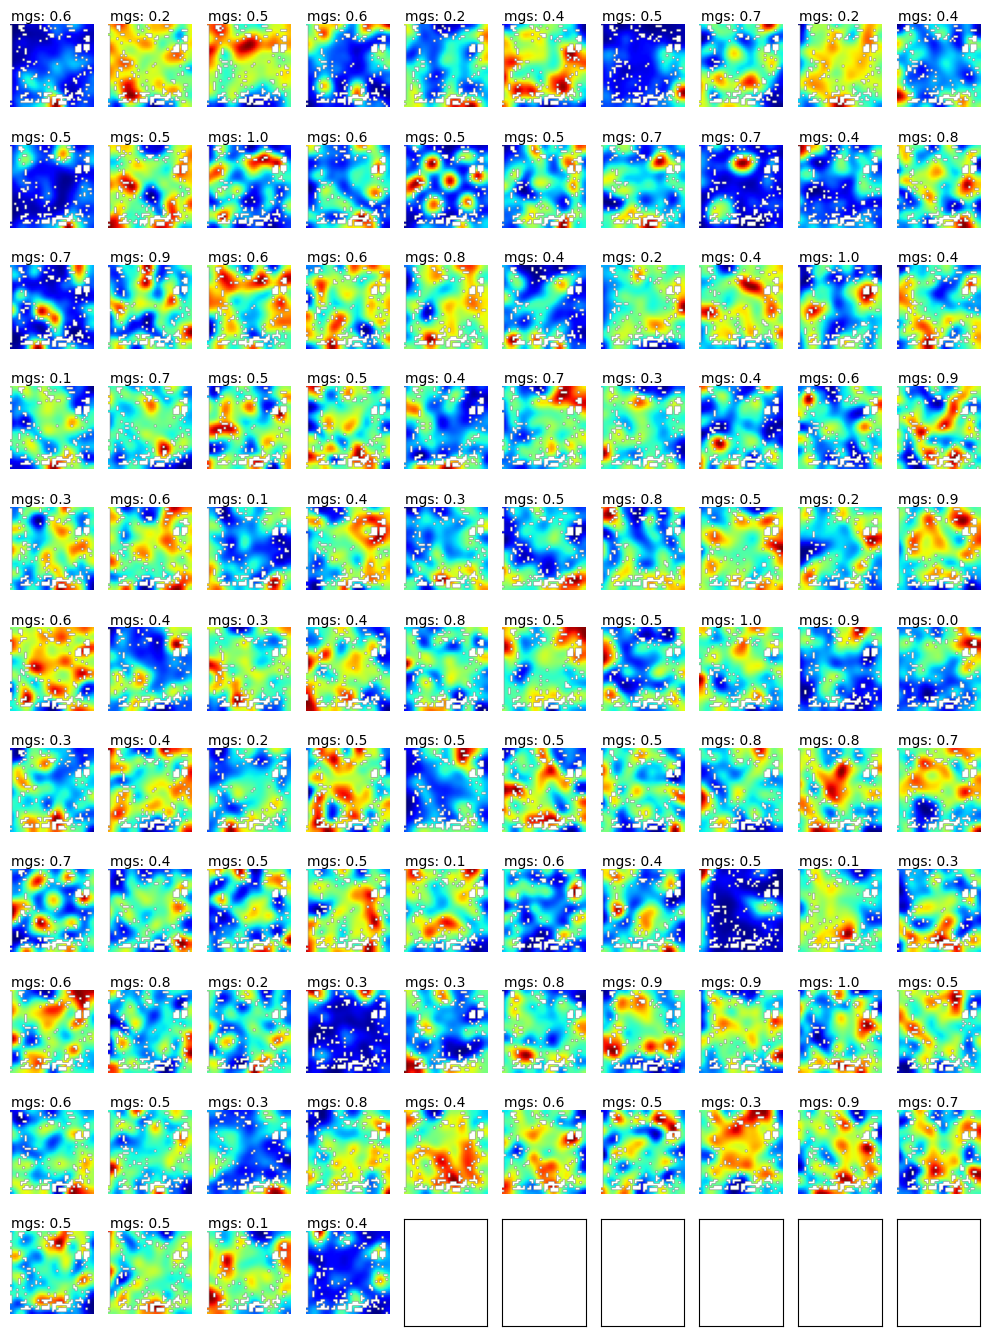

In [90]:
for cells, label in zip([grid_cells, non_grid_cells], ['grid_cells', 'Nongrids']):
    print(f'making plots for {label}')
    
    tcs = {}
    position = np.stack([beh['P_x'], beh['P_y']], axis=1)
    for cell in cells['cluster_id'].values:
        tc = nap.compute_2d_tuning_curves(nap.TsGroup([clusters[cell]]), position, nb_bins=(40,40))[0]
        tc = gaussian_filter_nan(tc[0], sigma=(2.5,2.5))
        tcs[cell] = tc
    
    ncols = 10
    nrows = int(np.ceil(len(tcs)/ncols))
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*(np.ceil(len(tcs)/6)/4)), squeeze=False)
    counter = 0
    for j in range(nrows):
        for i in range(ncols):
            if counter<len(tcs):
                index = cells['cluster_id'].values[counter]
                score = cells['grid_score'].values[counter]
                ax[j, i].text(0,-2, f'gs: {np.round(score, decimals=1)}')
                ax[j, i].imshow(tcs[index], cmap='jet')
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
            ax[j, i].spines['top'].set_visible(False)
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['bottom'].set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
            counter+=1
    plt.tight_layout()
    plt.show()


    ncols = 10
    nrows = int(np.ceil(len(tcs)/ncols))
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*(np.ceil(len(tcs)/6)/4)), squeeze=False)
    counter = 0
    for j in range(nrows):
        for i in range(ncols):
            if counter<len(cells['cluster_id']):
                index = cells['cluster_id'].values[counter]
                score = cells['grid_score'].values[counter]

                cluster_shifted_grid_scores = shifted_grid_scores_of1[shifted_grid_scores_of1.cluster_id==index]
                max_score = np.nanmax(cluster_shifted_grid_scores.grid_score)
                percentile = np.nanpercentile(cluster_shifted_grid_scores.null_grid_score.iloc[0], percentile_val)

                ax[j, i].axvline(0, color='grey')
                ax[j, i].axhline(0, color='grey')
                ax[j, i].axhline(percentile, color='red', linestyle='solid', linewidth=0.5)
                ax[j, i].scatter(cluster_shifted_grid_scores.travel, cluster_shifted_grid_scores.grid_score, s=2, color='black')            
                ax[j, i].text(-50,1, f'gs: {np.round(score, decimals=1)}, mgs: {np.round(max_score, decimals=1)}', size=6)

            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].set_ylim([-1,1])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
            ax[j, i].spines['top'].set_visible(False)
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['bottom'].set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
            counter+=1
    plt.tight_layout()
    plt.show()

    
    ncols = 10
    nrows = int(np.ceil(len(tcs)/ncols))
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*(np.ceil(len(tcs)/6)/4)), squeeze=False)
    counter = 0
    for j in range(nrows):
        for i in range(ncols):
            if counter<len(tcs):
                index = cells['cluster_id'].values[counter]
                score = cells['grid_score'].values[counter]
                cluster_shifted_grid_scores = shifted_grid_scores_of1[shifted_grid_scores_of1.cluster_id==index]
                travel = cluster_shifted_grid_scores.travel.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]
                max_score = cluster_shifted_grid_scores.grid_score.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]

                tcs = {}
                beh_lag = compute_travel_projected(["P_x", "P_y"], position, position, travel)
                position_lagged = np.stack([beh_lag['P_x'], beh_lag['P_y']], axis=1)
                for cell in cells['cluster_id'].values:
                    tc = nap.compute_2d_tuning_curves(nap.TsGroup([clusters[cell]]), position_lagged, nb_bins=(40,40))[0]
                    tc = gaussian_filter_nan(tc[0], sigma=(2.5,2.5))
                    tcs[cell] = tc
                index = cells['cluster_id'].values[counter]
                score = cells['grid_score'].values[counter]
                ax[j, i].text(0,-2, f'mgs: {np.round(max_score, decimals=1)}')
                ax[j, i].imshow(tcs[index], cmap='jet')
                ax[j, i].spines['top'].set_visible(False)
                ax[j, i].spines['right'].set_visible(False)
                ax[j, i].spines['bottom'].set_visible(False)
                ax[j, i].spines['left'].set_visible(False)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
            counter+=1
    plt.tight_layout()
    plt.show()


